# Bad Pixels

Initially written for the bootcamp at SLAC Nov 2018 by Imran, Andrew, and Andrés 

In [ ]:
! eups list -s | grep lsst_distrib

## Imports

In [158]:
%matplotlib inline

# system imports
from matplotlib import pylab as plt
from scipy.optimize import leastsq
import numpy
import os

# LSST stack imports
from lsst.daf.persistence import Butler
import lsst.afw.display as afwDisplay
from lsst.ip.isr import IsrTask
import lsst.afw.detection as afwDetection
from lsst.ip.isr import isrFunctions
import lsst.afw.cameraGeom.utils as cameraGeomUtils
import lsst.afw.image as afwImage



## LSST Stack BPM

In [43]:
#Get master dark and master flat

In [48]:
print(butler.queryMetadata('raw', ['visit'], dataId={'imageType': 'FLAT'})) #Change type to 'DARK' to get ID of a dark file. 

[258333657, 258333691, 258333725, 258333759, 258334082, 258334094, 258339739, 258339769, 258339807, 258339839, 258339875, 258339908, 258339945, 258339976, 258340014, 258340047, 258340086, 258340120, 258340159, 258340176, 258340202, 258340220, 258340244, 258340265, 258340290, 258340314, 258340341, 258340363, 258340392, 258340416, 258340449, 258340477, 258340511, 258340542, 258340581, 258340618, 258340662, 258340707, 258340758, 258340811, 258340873, 258340939, 258341017, 258341101, 258341198, 258341305, 258341426, 258341550, 258341693, 258341830, 258341990, 258342143, 258342307, 258342465, 258342632, 258342795, 258342968, 258343136, 258343313, 258343485, 258343670, 258343846, 258344037, 258344222, 258344422, 258344616, 258344826, 258345029, 258345246, 258345458, 258345684, 258345905, 258346139, 258346369, 258346613, 258346852, 258347105, 258347351, 258347613, 258347868, 258348138, 258348402, 258348695, 258348982, 258350677, 258350700, 258350725, 258350751, 258350774, 258350797, 258350822

In [159]:
# use first ID from previous cell
BOOTCAMP_REPO_DIR= '/project/bootcamp/repo_RTM-007/'
butler = Butler(BOOTCAMP_REPO_DIR)
dId_dark = {'visit': 258334666, 'detector': 4}
dId_flat = {'visit': 258333657, 'detector': 4}

dark = butler.get('dark', **dId_dark)
flat = butler.get('flat', **dId_flat)


2


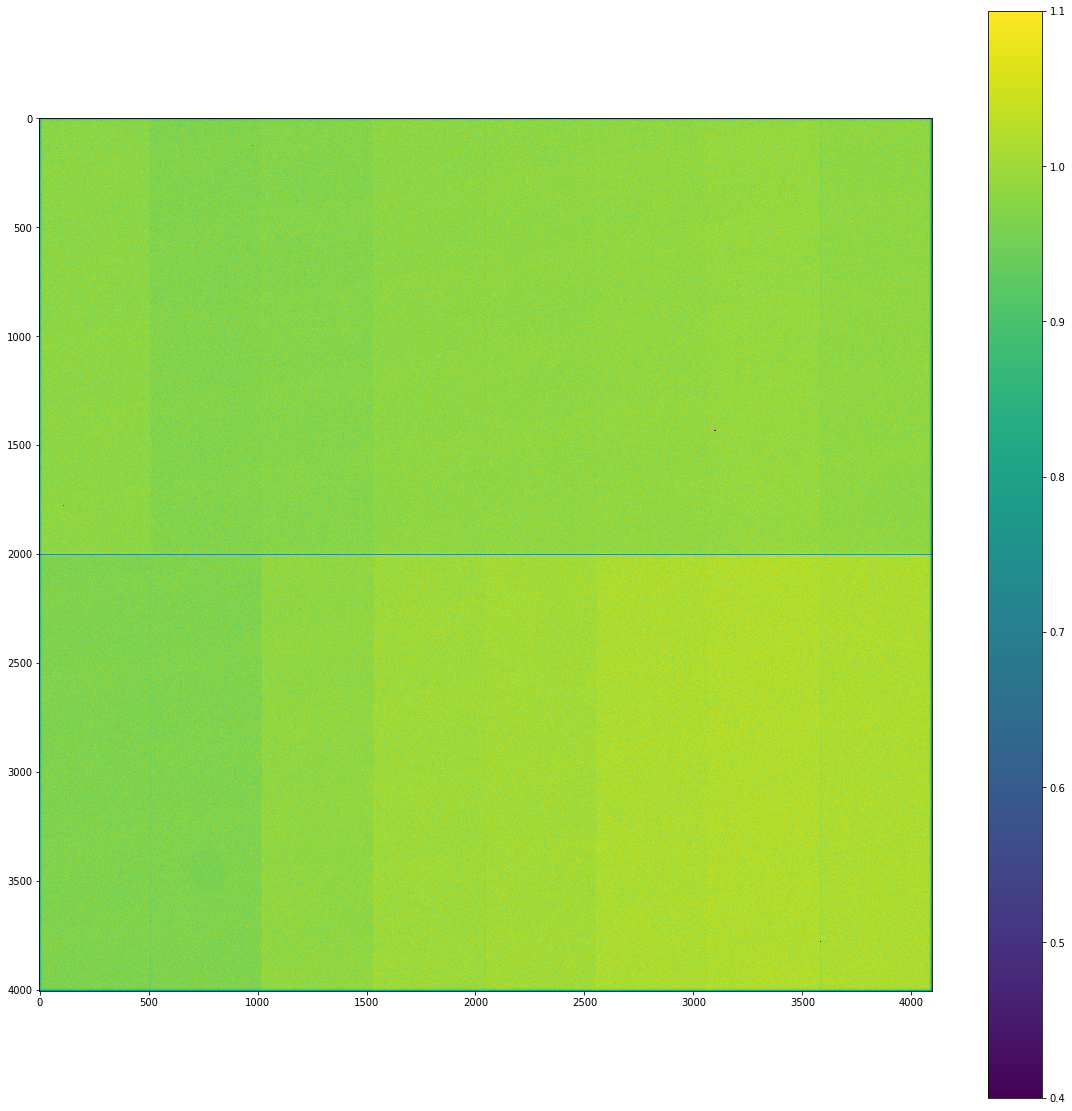

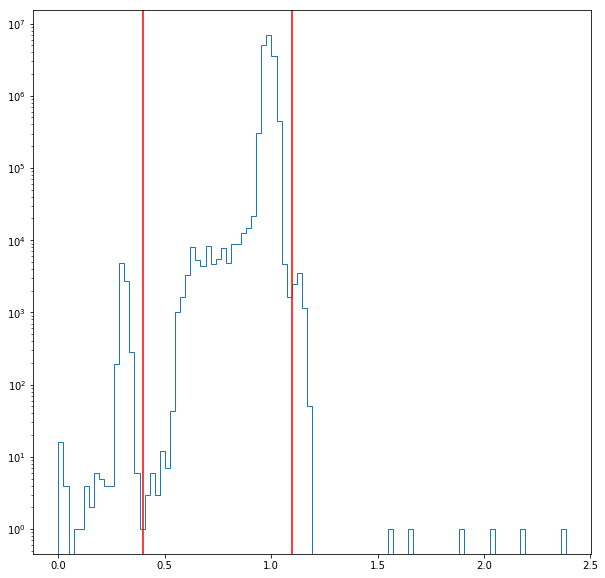

In [109]:
min_flat, max_flat = 0.4, 1.1
flat_array=flat.getMaskedImage().getImage().getArray()
bad_pix_flat=numpy.where( (flat_array < min_flat) | (flat_array > max_flat))
print (len(bad_pix_flat))
plt.figure(figsize=(20,20))
plt.imshow(flat.getMaskedImage().getImage().getArray(), vmin=min_flat, vmax=max_flat)
plt.colorbar();
plt.figure(figsize=(10,10))
plt.hist (flat.getMaskedImage().getImage().getArray().flatten(), bins=100, histtype='step')
plt.axvline(min_flat, c='r')
plt.axvline(max_flat, c='r')
plt.yscale('log')

(array([   0,    0,    0, ..., 4003, 4003, 4003]), array([  51,  329,  330, ..., 3898, 3932, 3933]))


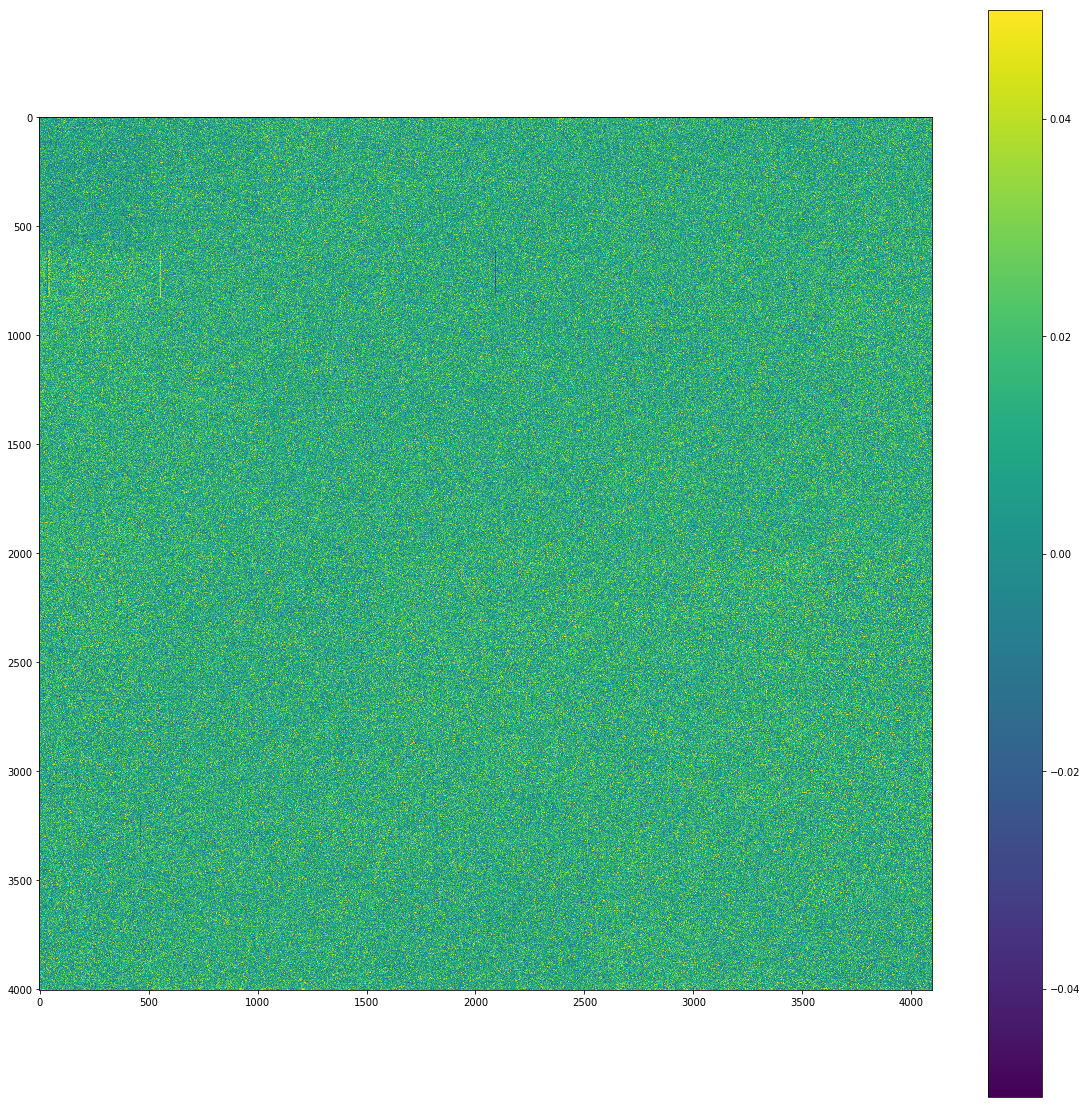

In [103]:
min_dark, max_dark = -0.05, 0.05
dark_array=dark.getMaskedImage().getImage().getArray()
bad_pix_dark=numpy.where((dark_array < min_dark) | (dark_array > max_dark))
print (bad_pix_dark)
plt.figure(figsize=(20,20))
plt.imshow(dark_array, vmin= min_dark, vmax= max_dark)
plt.colorbar();
plt.figure(figsize=(10,10))
plt.hist (dark_array.flatten(), bins=100, histtype='step')
plt.axvline(min_dark, c='r')
plt.axvline(max_dark, c='r')
plt.yscale('log')

In [81]:
# Make footprints

(array([   0,    0,    1, ..., 4002, 4003, 4003]), array([   0, 4095,    0, ..., 4095,    0, 4095]))
(array([   0,    0,    0, ..., 4003, 4003, 4003]), array([  51,  329,  330, ..., 3898, 3932, 3933]))


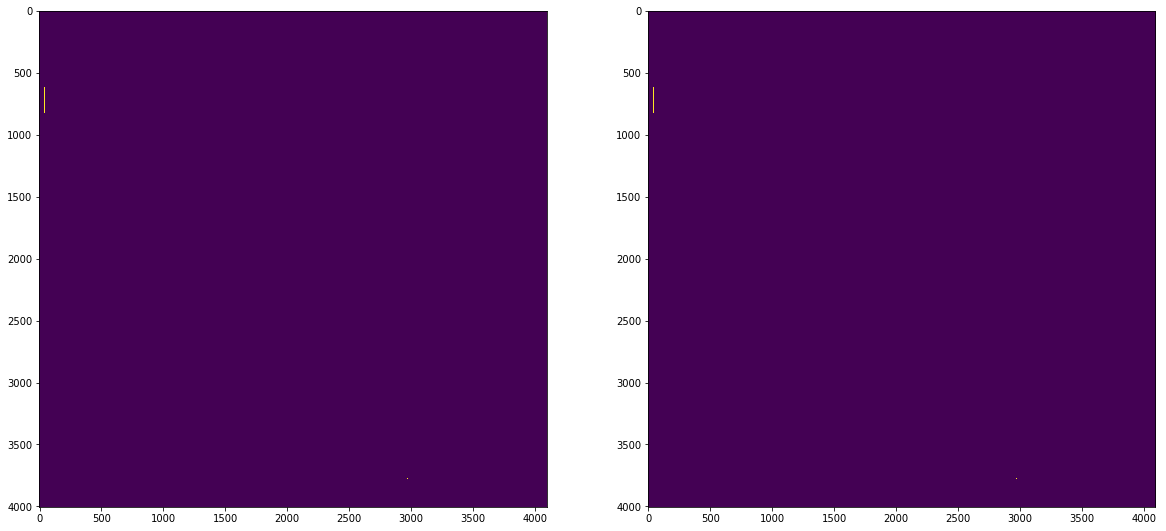

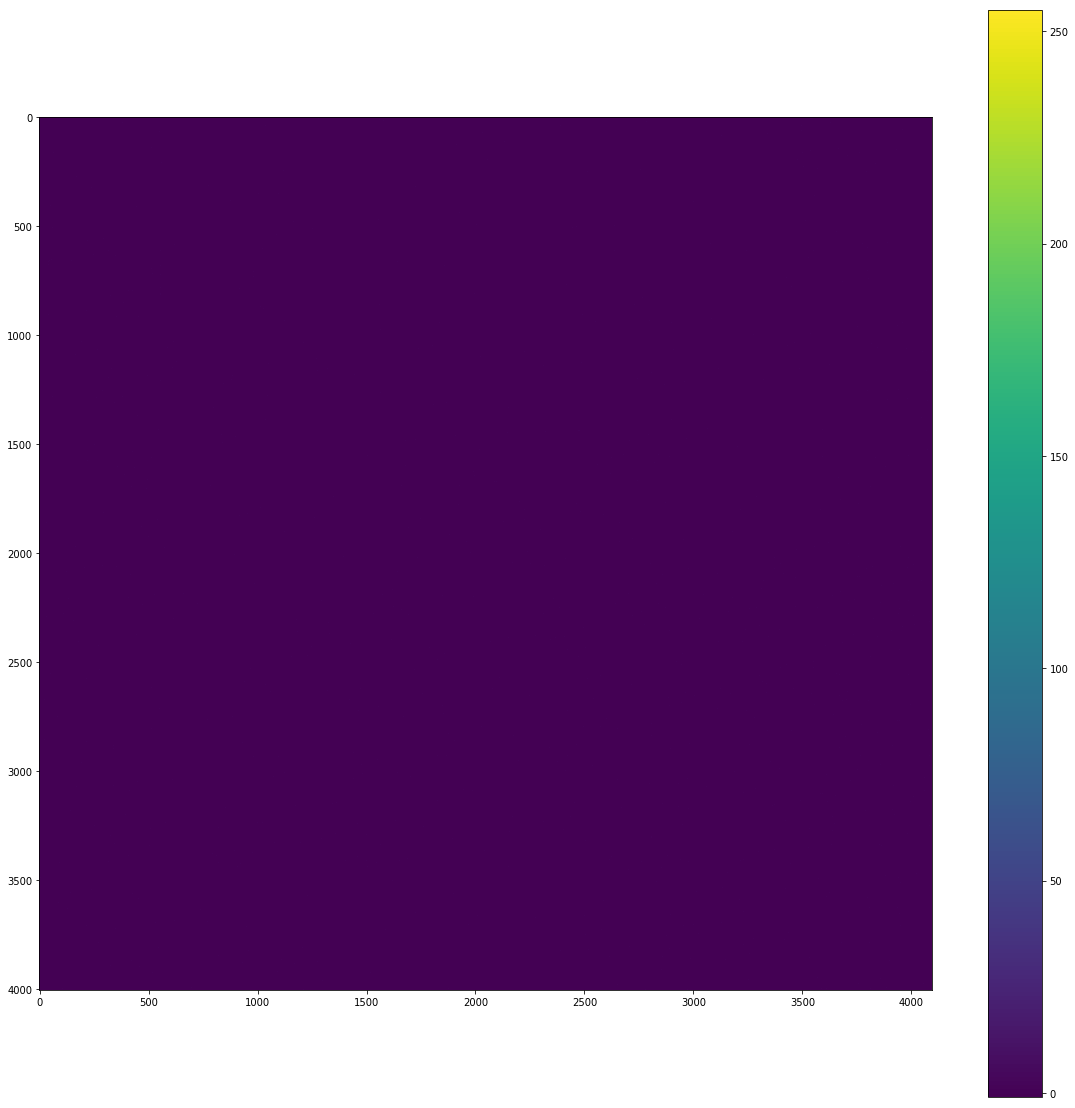

In [116]:
print (bad_pix_flat)
print (bad_pix_dark)

dark.getMaskedImage().mask.array[bad_pix_dark]=1
flat.getMaskedImage().mask.array[bad_pix_flat]=1
plt.figure (figsize=(20,10))
plt.subplot(121)
plt.imshow(dark.getMaskedImage().mask.array)
plt.subplot(122)
plt.imshow(flat.getMaskedImage().mask.array)


#plt.figure (figsize=(20,20))
#plt.subplot(111)
#plt.imshow(dark.getMaskedImage().mask.array - flat.getMaskedImage().mask.array)
#plt.colorbar()

(4004, 4096)


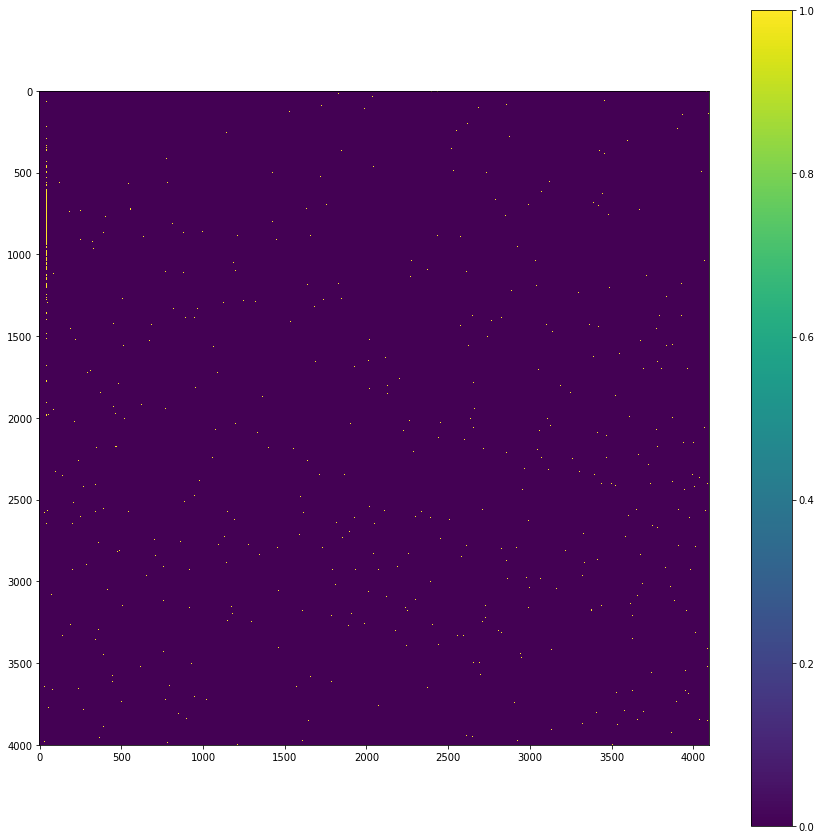

In [142]:
final_bpm = dark.getMaskedImage().mask.array + flat.getMaskedImage().mask.array
index=numpy.where (final_bpm>=1)
final_bpm[index]=1
print (final_bpm.shape)

plt.figure (figsize=(15,15))
plt.imshow(final_bpm)
plt.colorbar()

## EOTest

### Read in the bad pixel mask from eotest

In [124]:
amps = {}
for i in range(16):
    exp = afwImage.ExposureU('/project/bootcamp/data/LCA-11021_RTM-007/7086/bright_defects_raft/v0/44990/S11/E2V-CCD250-195_bright_pixel_mask.fits[%i]'%(i))
    md = exp.getMetadata()
    amps[md.get('EXTNAME')] = exp

/opt/lsst/software/stack/python/miniconda3-4.5.4/envs/lsst-scipipe-fcd27eb/lib/python3.6/site-packages/ipykernel/__main__.py:5: DeprecationWarning: Use getArray or getScalar instead


In [125]:
from lsst.obs.lsst.ts8 import Ts8Mapper
mapper = Ts8Mapper()

In [126]:
detector = mapper.camera['R00_S11']

In [144]:
outIm = afwImage.ImageU(detector.getBBox())

In [145]:
for key, item in amps.items():
    amp_name = 'C%s'%(key[-2:])
    amp = detector[amp_name]
    amp_im = amps[key].getMaskedImage().getImage()
    arr = amp_im[amp.getRawDataBBox()].getArray()
    if amp.getRawFlipX():
        arr = numpy.flip(arr, axis=1)
    if amp.getRawFlipY():
        arr = numpy.flip(arr, axis=0)
    box = amp.getBBox()
    outView = outIm[box].getArray()
    outView[:] = arr

In [150]:
eo_bpm = outIm.getArray()
print (eo_bpm.shape)

(4004, 4096)


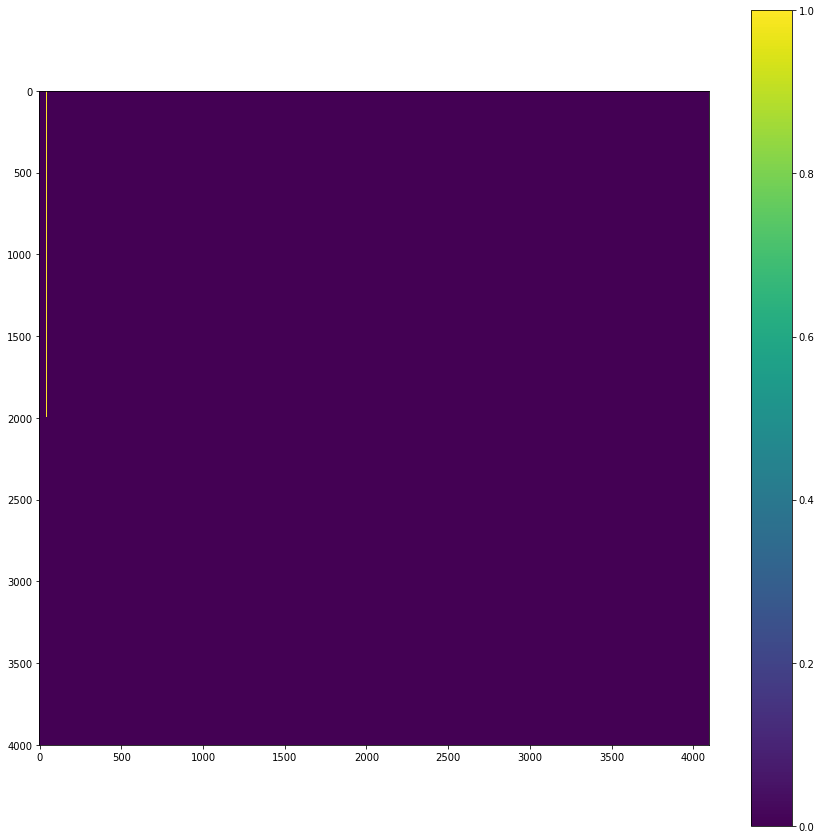

In [151]:
plt.figure(figsize=(15,15))
plt.imshow(eo_bpm)
plt.colorbar()


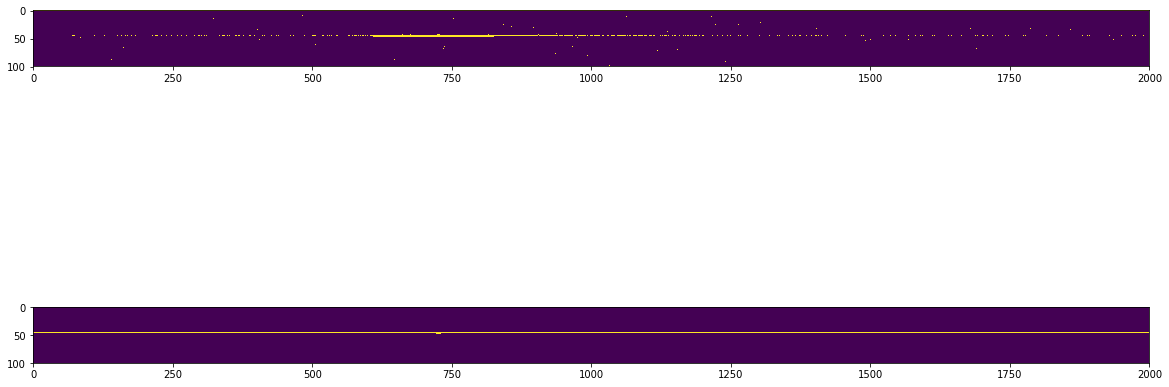

In [157]:
plt.figure(figsize=(20,10))
plt.subplot(211)
plt.imshow(final_bpm[0:2000, 0:100].T)
plt.subplot(212)
plt.imshow(eo_bpm[0:2000, 0:100].T)
